In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
from scipy.interpolate import griddata # Other package for regridding
from scipy.stats import genextreme as gev

# Import some extra functions from utils folder
import sys
sys.path.insert(1, '/home/philinat') # to include the util directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}

3.8.5 | packaged by conda-forge | (default, Sep 24 2020, 16:55:52) 
[GCC 7.5.0]
Virtual memory usage - total: 187 GB / available: 134 GB / percent used: 28.4 %


In [60]:
ds_APGD = xr.open_dataset('/bettik/menegozm/EURO4M_APGD/06-coord_lonlat.nc').rename_vars({'Longitude':'LON','Latitude':'LAT'})
les_season_mean0 = np.load('/home/philinat/Stage-M2/saved_data_APGD/les_season_mean0.npy')
les_season_max0 = np.load('/home/philinat/Stage-M2/saved_data_APGD/les_season_max0.npy')

les_season_mean0[ les_season_mean0==0 ] = np.nan

ds_in = xr.Dataset(
    data_vars=dict(p_mean=(["time","season","y","x"], les_season_mean0),
                    p_max=(["time","season","y","x"], les_season_max0)),
    coords=dict(lon=(["y","x"], ds_APGD.LON.data),
                lat=([ "y","x"], ds_APGD.LAT.data),
                season=np.arange(4),
                time=np.arange(1971,2009,1)))

ds_MAR = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/MARgrid_EUf.nc')

ds_out = xr.Dataset(
    coords=dict(lon=(["y","x"], ds_MAR.LON.data),
                lat=([ "y","x"], ds_MAR.LAT.data),
                season=np.arange(4),
                time=np.arange(1971,2009,1)))

regridder = xe.Regridder(ds_in, ds_out, 'bilinear')
ds_out = regridder(ds_in)

Overwrite existing file: bilinear_138x243_126x201.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('y', 'x') from data variable p_mean as the horizontal dimensions for this dataset.


/home/philinat/miniconda3/envs/erca/lib/python3.8/site-packages/xesmf/frontend.py:477: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [61]:
ds_out

<xarray.Dataset>
Dimensions:  (time: 38, season: 4, y: 126, x: 201)
Coordinates:
  * season   (season) int64 0 1 2 3
  * time     (time) int64 1971 1972 1973 1974 1975 ... 2004 2005 2006 2007 2008
    lon      (y, x) float32 1.386 1.47 1.554 1.638 ... 19.51 19.6 19.7 19.79
    lat      (y, x) float32 41.68 41.68 41.69 41.69 ... 49.06 49.05 49.04 49.03
Dimensions without coordinates: y, x
Data variables:
    p_mean   (time, season, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    p_max    (time, season, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

In [64]:
les_season_mean = ds_out.p_mean.data
les_season_max = ds_out.p_max.data
np.save('/home/philinat/Stage-M2/saved_data_APGD/les_season_mean.npy', les_season_mean)
np.save('/home/philinat/Stage-M2/saved_data_APGD/les_season_max.npy', les_season_max)

In [65]:
les_season_mean = np.load('/home/philinat/Stage-M2/saved_data_APGD/les_season_mean.npy')
les_season_max = np.load('/home/philinat/Stage-M2/saved_data_APGD/les_season_max.npy')

(<matplotlib.lines.Line2D at 0x7f5f2ceefee0>,)

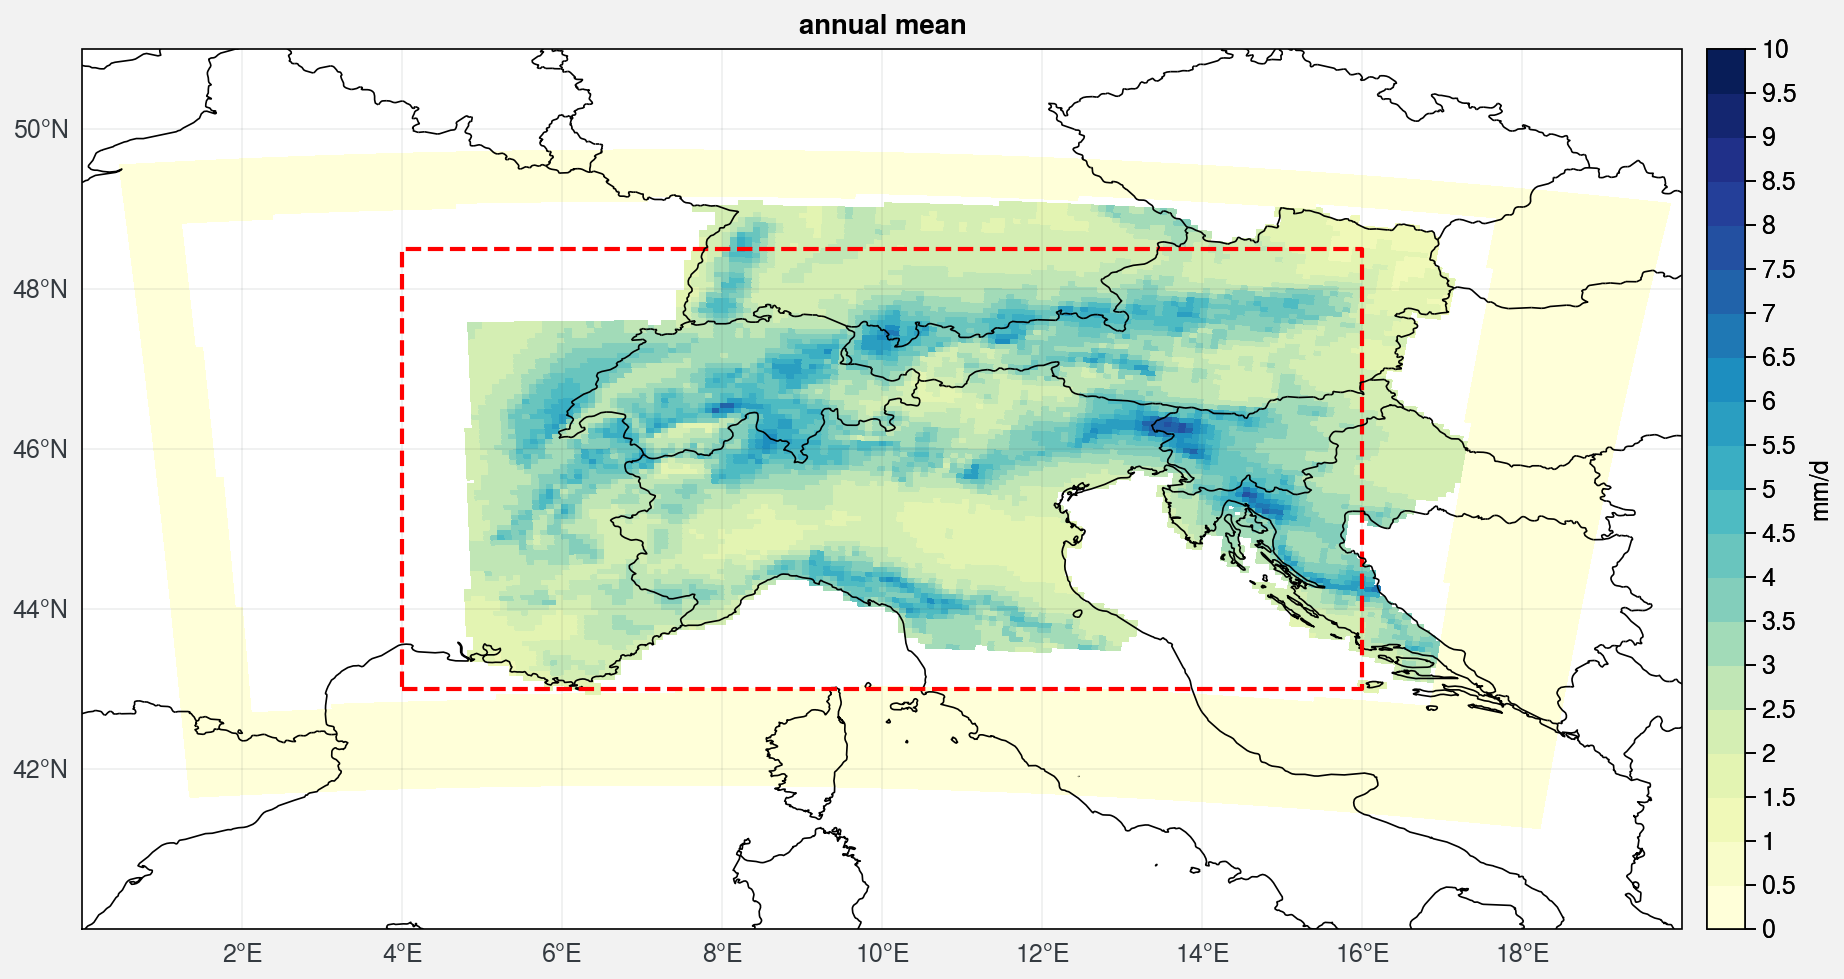

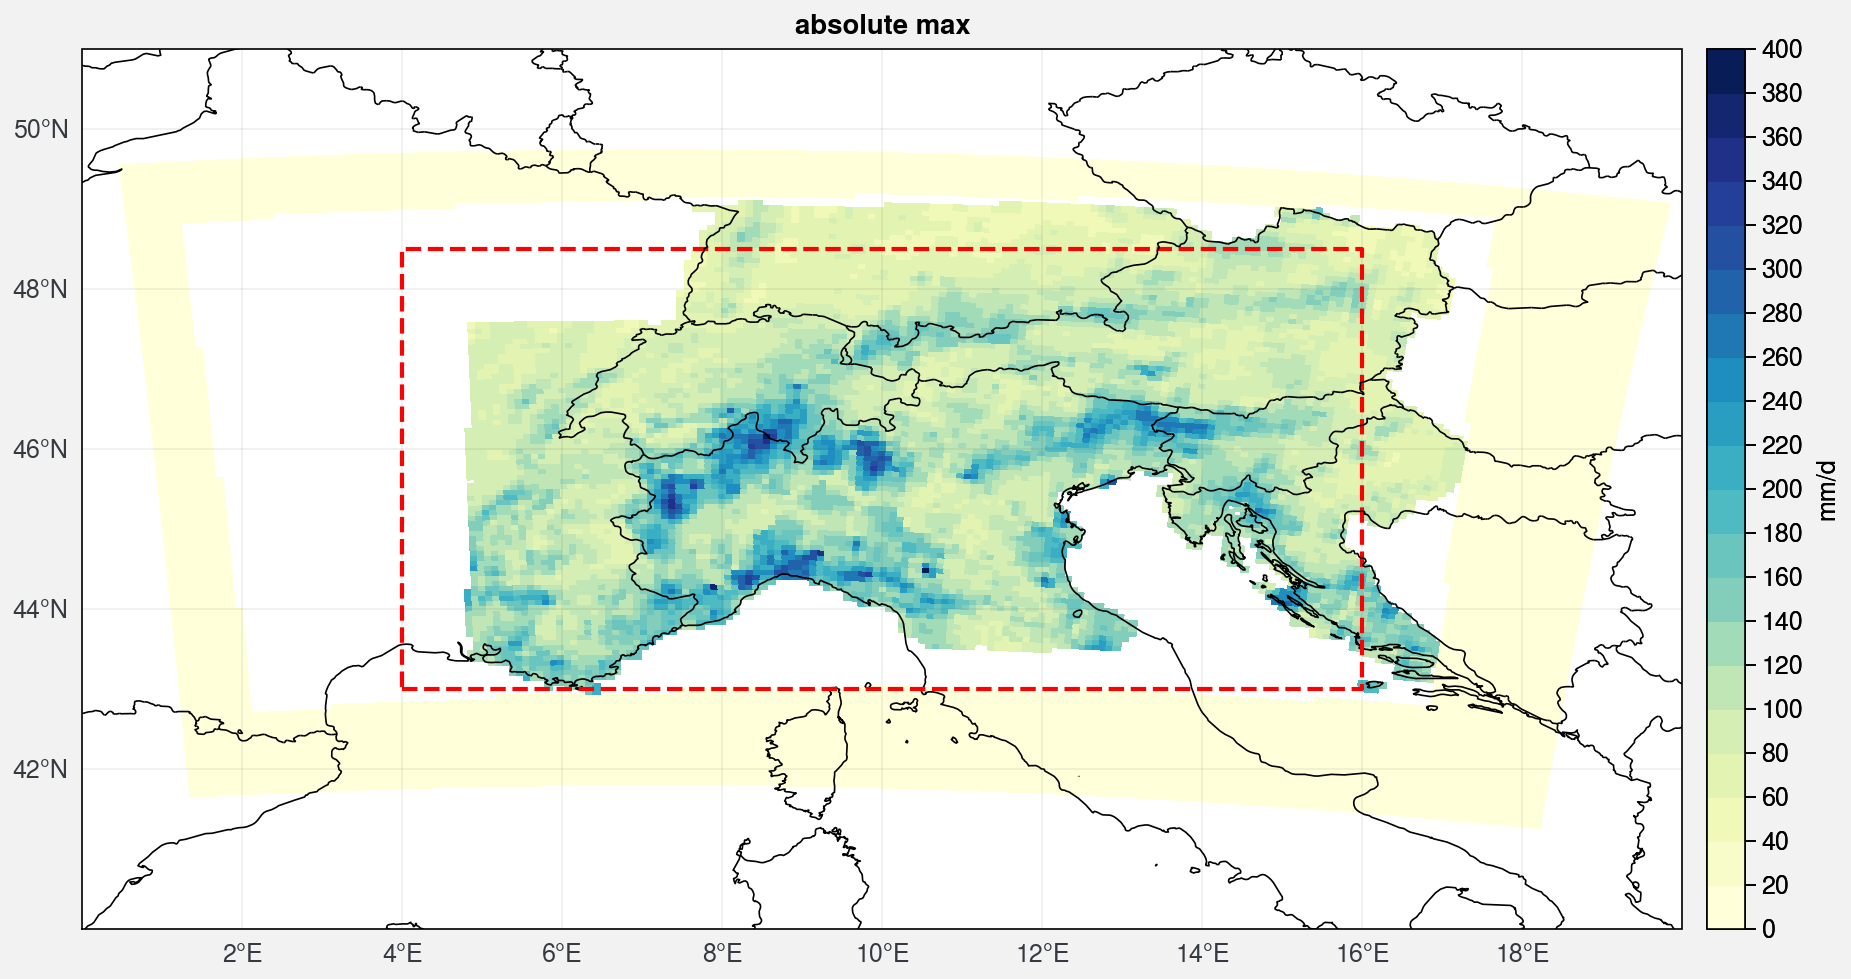

In [66]:

f, ax = pplt.subplots(proj='cyl', axwidth=8)
m=ax.pcolormesh(ds_out.lon, ds_out.lat, np.mean(les_season_mean[:,:,:,:],axis=(0,1)),levels=np.linspace(0,10,21),cmap='YlGnBu')
f.colorbar(m,label= 'mm/d')
ax.format(**normal_format,suptitle='annual mean')
ax.format(latlim=[40.,51.],lonlim=[0.,20.])
ax.plot([4.,16.,16,4,4],[43.,43,48.5,48.5,43],'--r')


f, ax = pplt.subplots(proj='cyl', axwidth=8)
m=ax.pcolormesh(ds_out.lon, ds_out.lat, np.max(les_season_max[:,:,:,:],axis=(0,1)),levels=np.linspace(0,400,21),cmap='YlGnBu')
f.colorbar(m,label= 'mm/d')
ax.format(**normal_format,suptitle='absolute max')
ax.format(latlim=[40.,51.],lonlim=[0.,20.])
ax.plot([4.,16.,16,4,4],[43.,43,48.5,48.5,43],'--r')

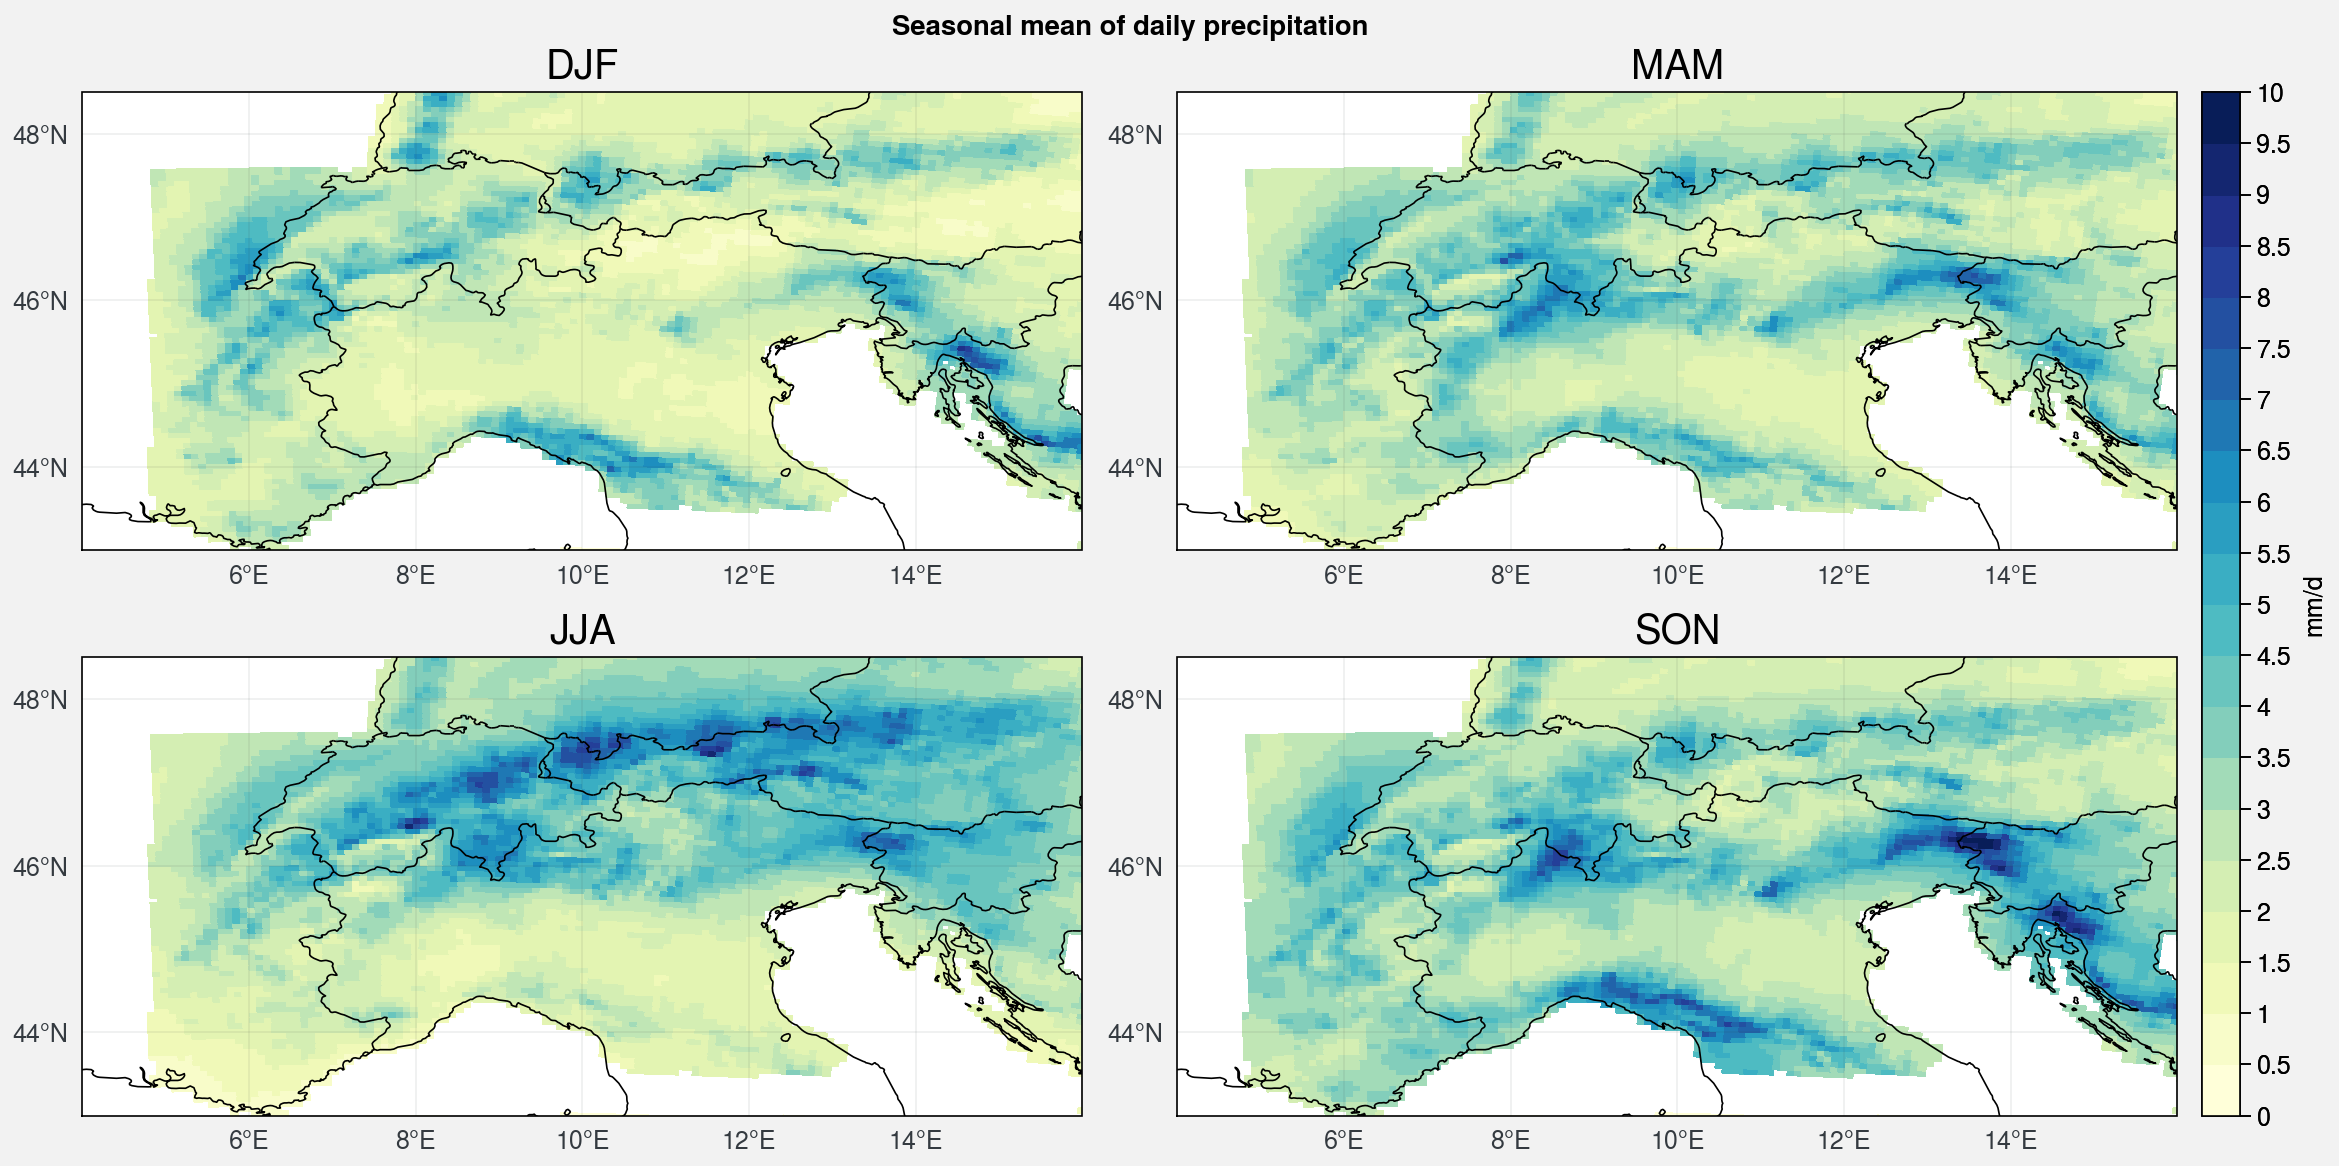

In [4]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/MARgrid_EUf.nc')
les_season_mean = np.load('/home/philinat/Stage-M2/saved_data_APGD/les_season_mean.npy')
seasonal_mean = np.mean(les_season_mean,axis=0)
f, axs = pplt.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    m = ax.pcolormesh(ds.LON,ds.LAT,seasonal_mean[i,:,:],levels=np.linspace(0,10,21),cmap='YlGnBu')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= 'mm/d')

axs.format(**normal_format,suptitle="Seasonal mean of daily precipitation")


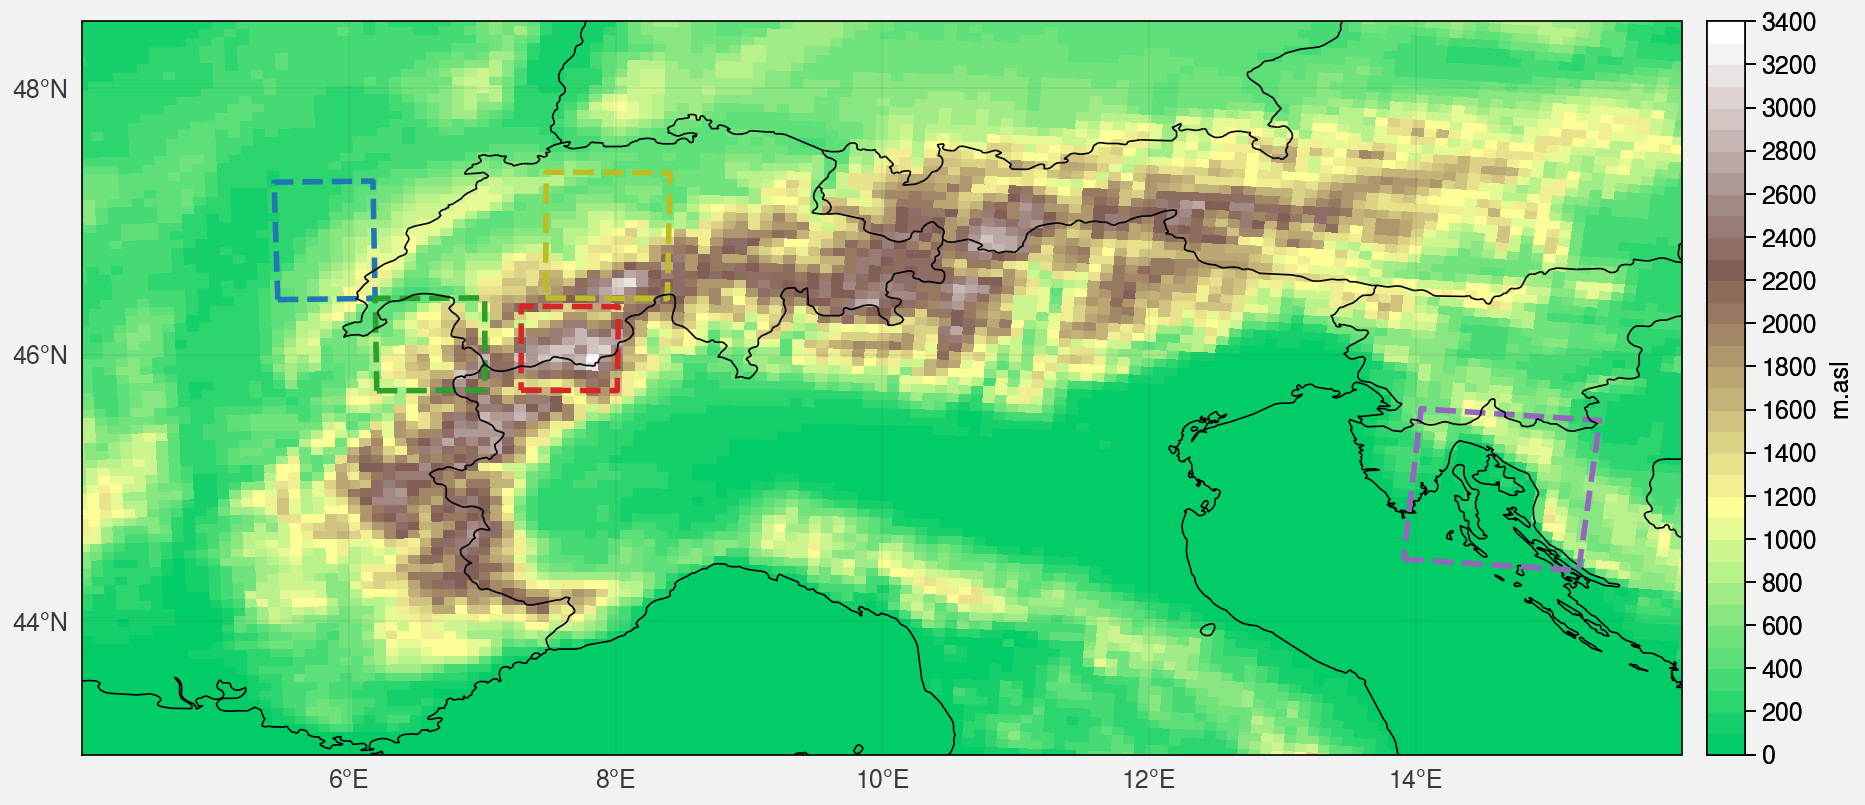

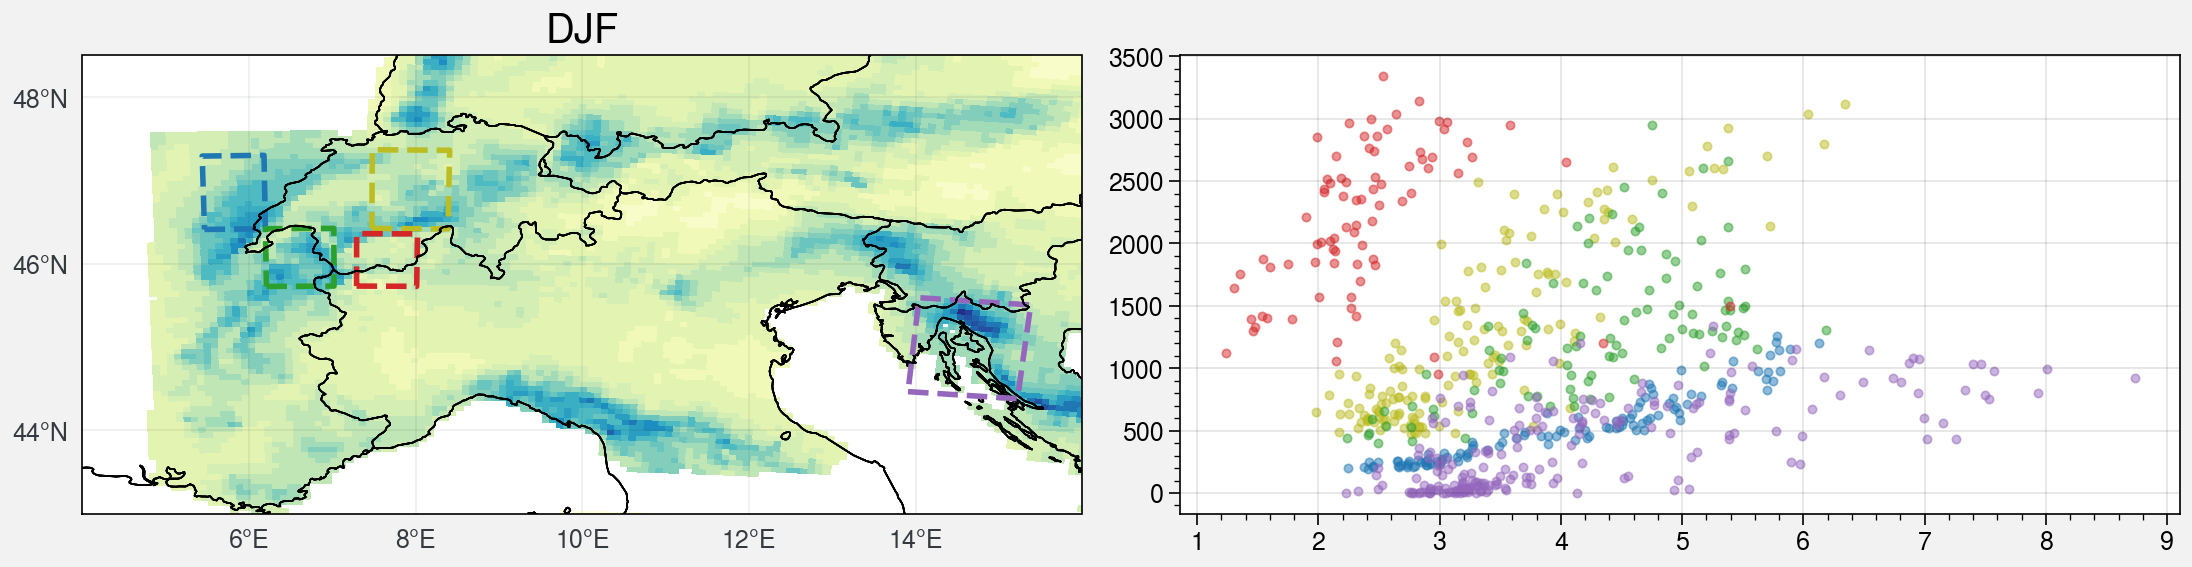

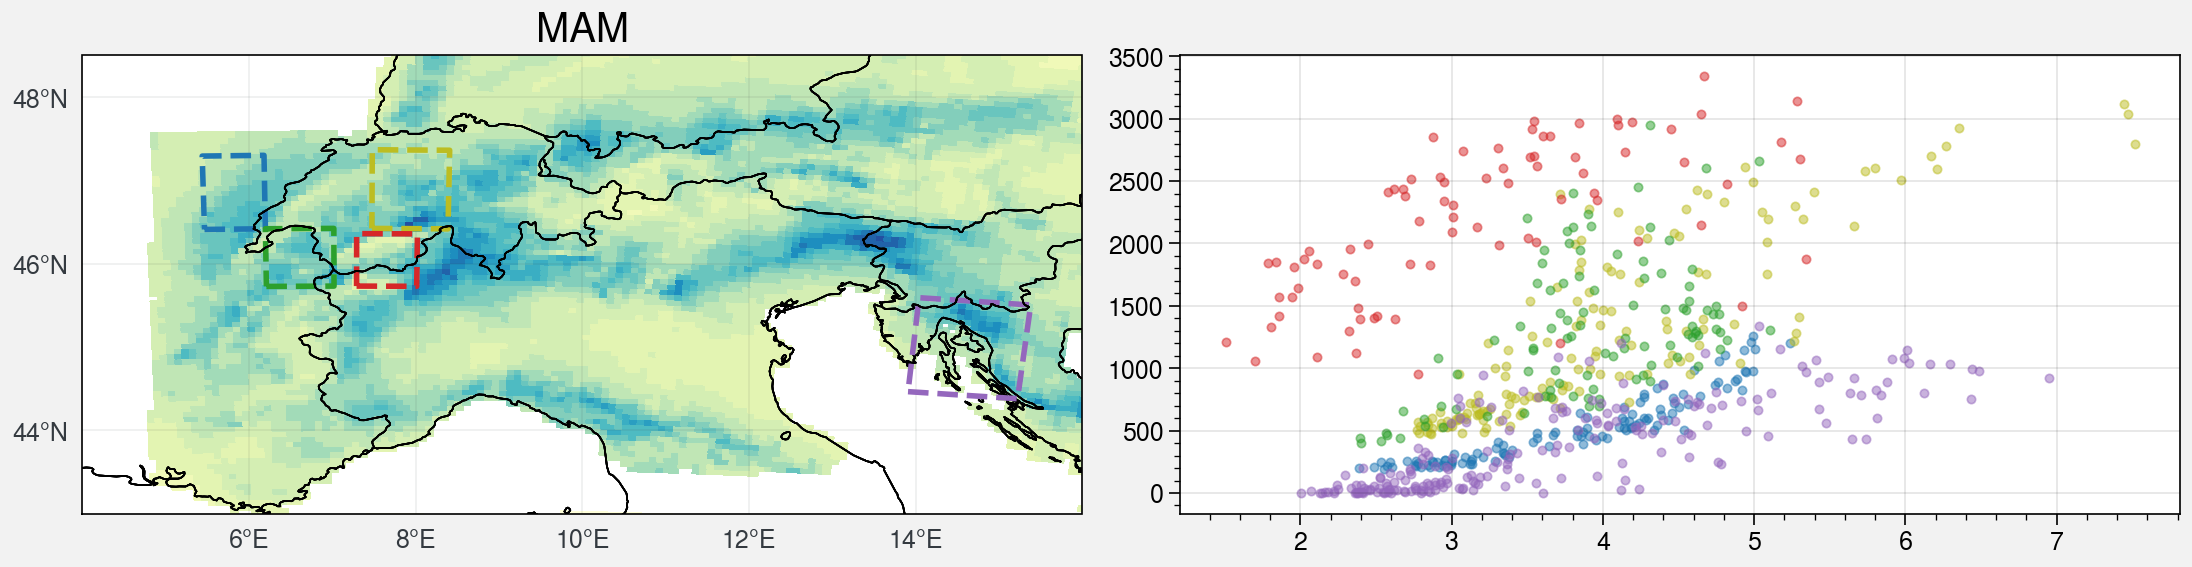

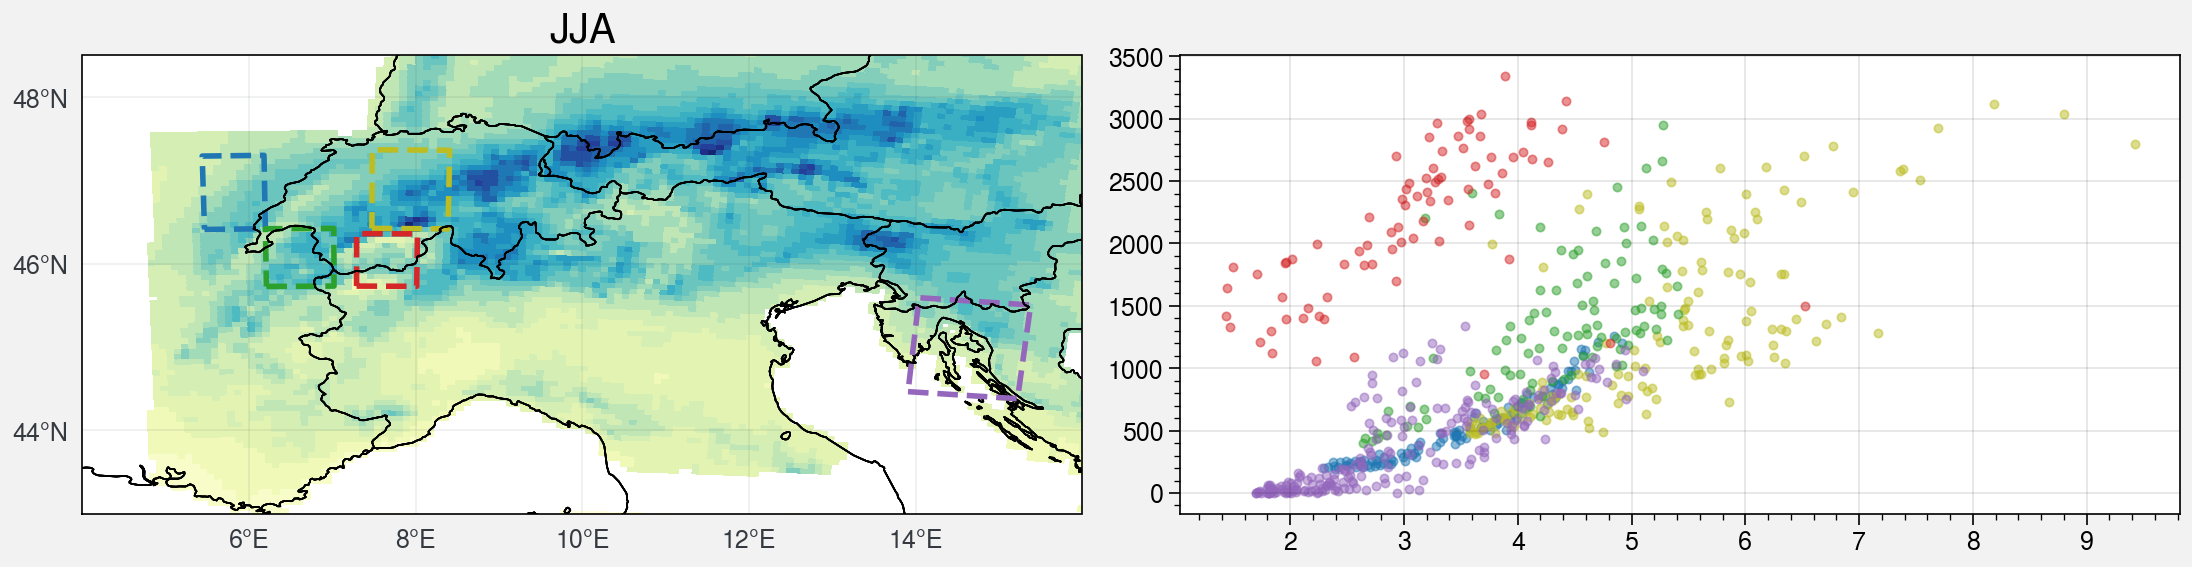

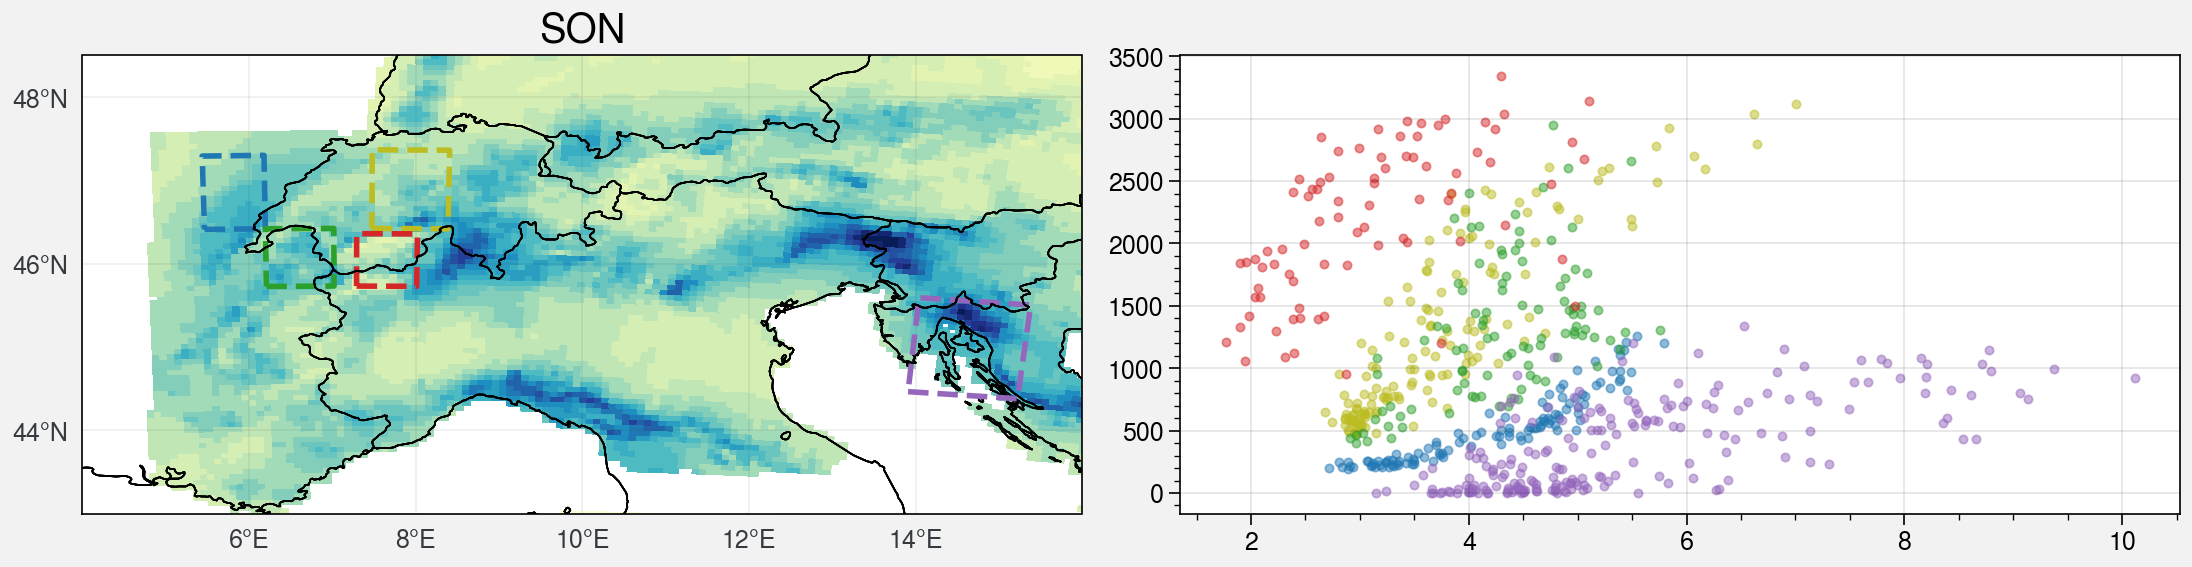

In [2]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/MARgrid_EUf.nc')
les_season_mean = np.load('/home/philinat/Stage-M2/saved_data_APGD/les_season_mean.npy')
seasonal_mean = np.mean(les_season_mean,axis=0)

colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
fh, axh = pplt.subplots(proj='cyl', axwidth=8)
m=axh.pcolormesh(ds.LON, ds.LAT, ds.SH, levels=34,cmap=colors_land)
fh.colorbar(m,label= 'm.asl')
axh.format(**normal_format)#,ocean=True,oceancolor='royalblue',suptitle='7km topography')

colors = ['#1f77b4','#bcbd22', '#2ca02c', '#d62728', '#9467bd',  '#ff7f0e', '#17becf']

for season in range(4):
    f, axs = pplt.subplots(proj=('cyl',None),ncols=2, nrows=1, share=1, axwidth=5)
    for region in range(5):
        if region==0:
            i1 = 50 ; i2 = 58 ; j1 = 73 ; j2 = 87 # jura
            # i1 = 100 ; i2 = 120 ; j1 = 35 ; j2 = 45 # appenins
        if region==1:
            i1 = 72 ; i2 = 82 ; j1 = 73 ; j2 = 88 # suisse
        if region==2:
            i1 = 58 ; i2 = 67 ; j1 = 62 ; j2 = 73 # savoie
        if region==3:
            i1 = 70 ; i2 = 78 ; j1 = 62 ; j2 = 72 # mont rose
        if region==4:
            i1 = 145 ; i2 = 160 ; j1 = 45 ; j2 = 63 # croatie
        if region==5:
            i1 = 123 ; i2 = 137 ; j1 = 84 ; j2 = 90 # grossglokner
            # i1 = 100 ; i2 = 130 ; j1 = 82 ; j2 = 92 # tirol
            # i1 = 105 ; i2 = 120 ; j1 = 65 ; j2 = 80 # sud tirol

        m = axs[0].pcolormesh(ds.LON,ds.LAT,seasonal_mean[season,:,:],levels=np.linspace(0,10,21),cmap='YlGnBu' )
        axs[0].format(**normal_format,title=['DJF','MAM','JJA', 'SON'][season],titlesize='20px')

        axs[0].plot( [ ds.LON[j1,i1],ds.LON[j1,i2],ds.LON[j2,i2],ds.LON[j2,i1],ds.LON[j1,i1] ],
                  [ ds.LAT[j1,i1],ds.LAT[j1,i2],ds.LAT[j2,i2],ds.LAT[j2,i1],ds.LAT[j1,i1] ] , '--',color=colors[region],linewidth=2)
        if season==0:
            axh.plot( [ ds.LON[j1,i1],ds.LON[j1,i2],ds.LON[j2,i2],ds.LON[j2,i1],ds.LON[j1,i1] ],
                  [ ds.LAT[j1,i1],ds.LAT[j1,i2],ds.LAT[j2,i2],ds.LAT[j2,i1],ds.LAT[j1,i1] ] , '--',color=colors[region],linewidth=2)
            
        h = np.array(ds.SH[j1:j2,i1:i2].stack(z=('x','y')) )
        p = np.ndarray.flatten(seasonal_mean[season,j1:j2,i1:i2],order='F')
        #p = seasonal_mean[season,j1:j2,i1:i2].stack(z=('x','y'))
        axs[1].scatter( p, h ,marker='.',alpha=0.5,color=colors[region])

        # m, b = np.polyfit(p, h, 1)
        # x= np.linspace(np.min(p),np.max(p),2)
        # axs[1].plot(x, m*x + b,color=colors[region])

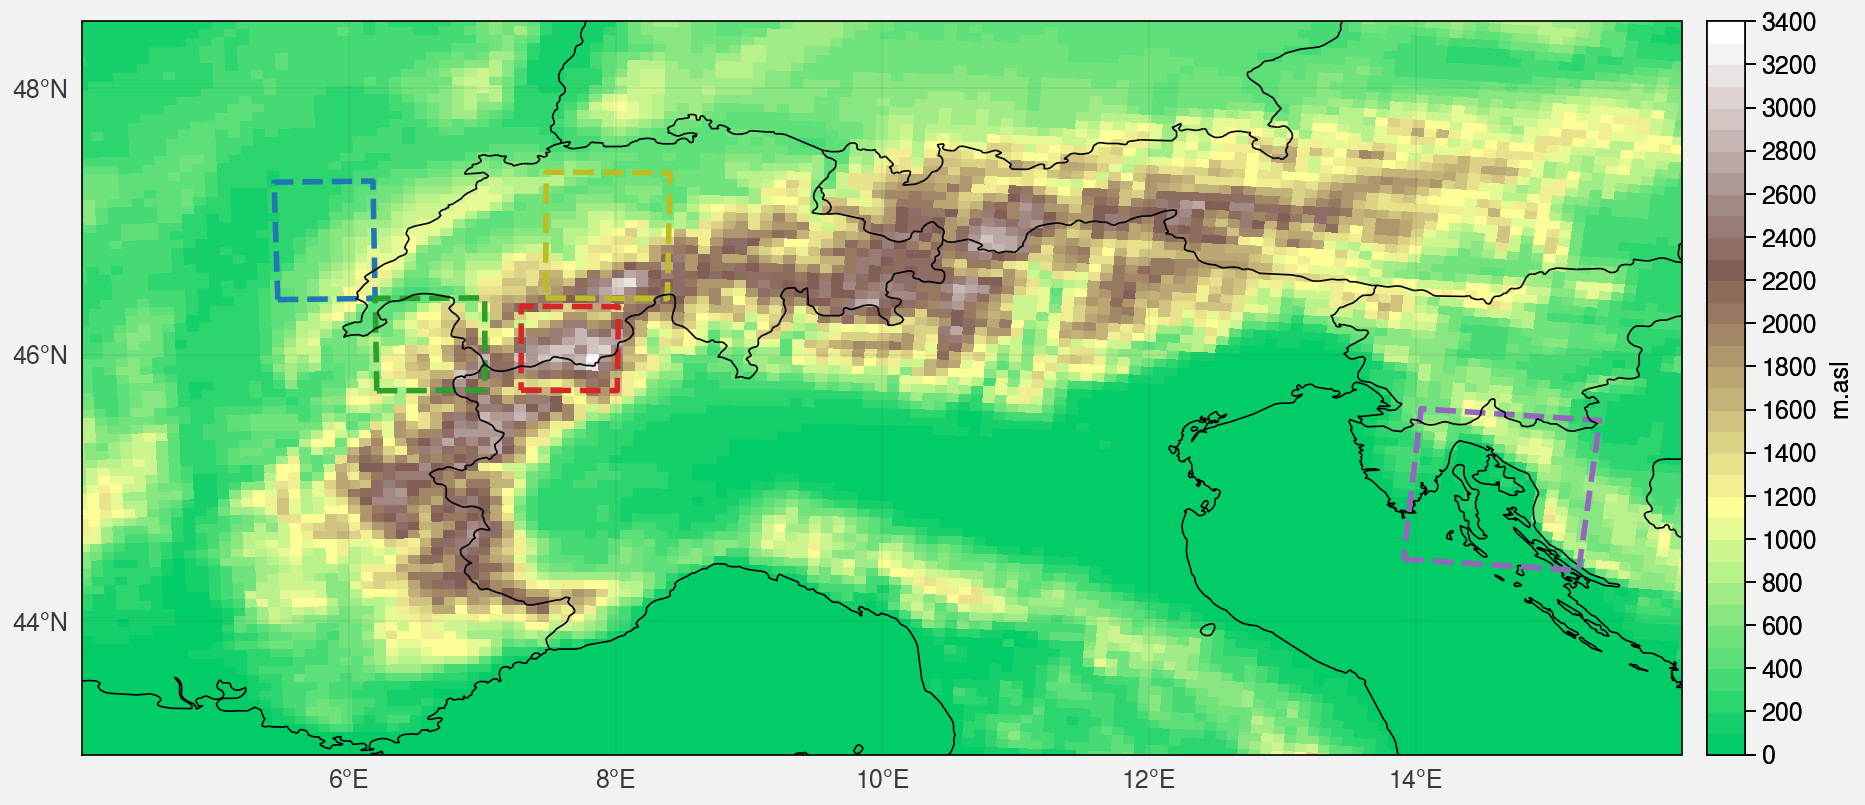

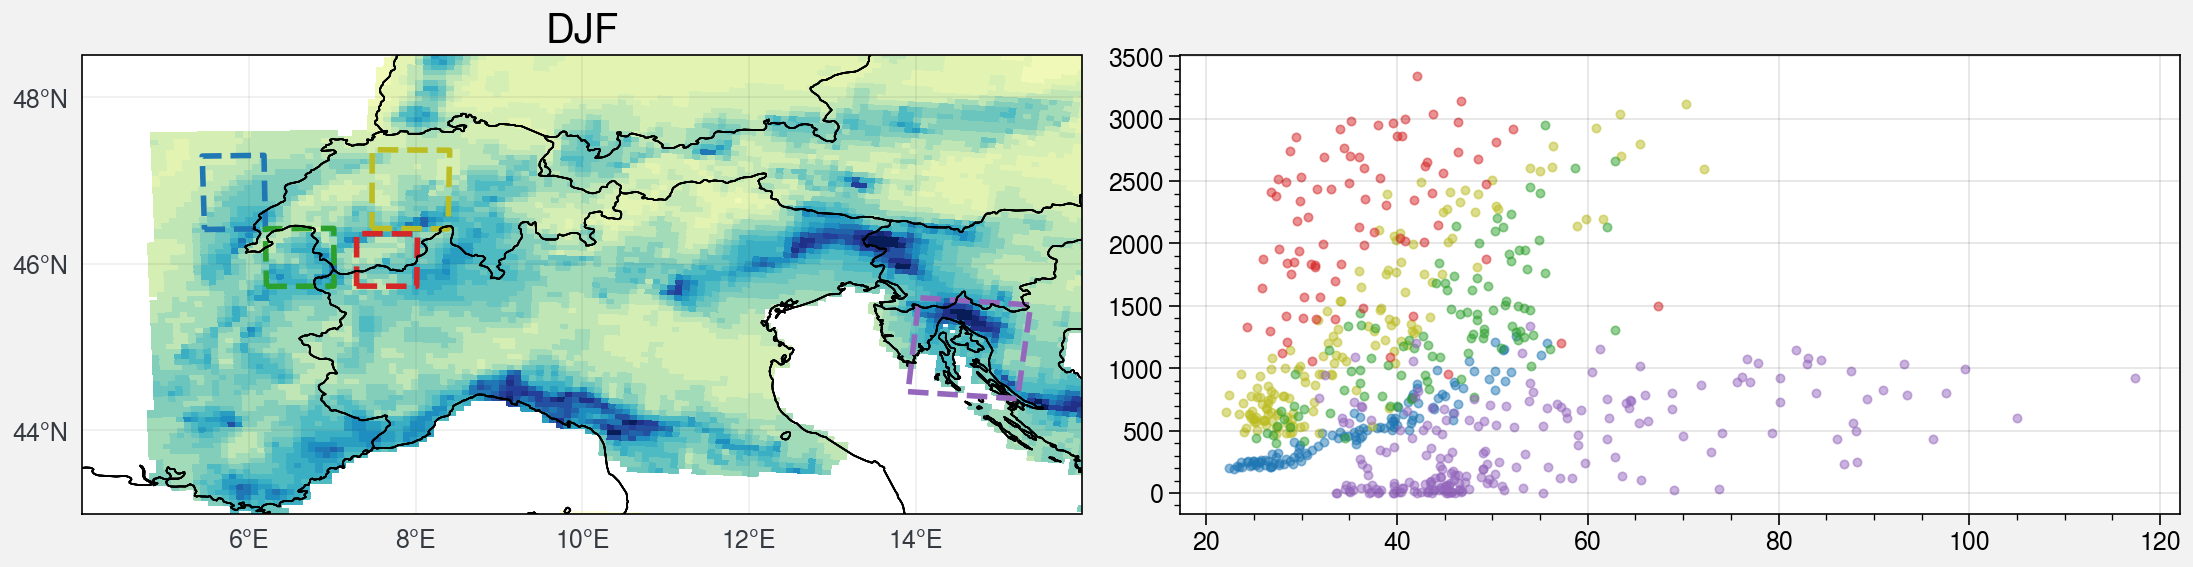

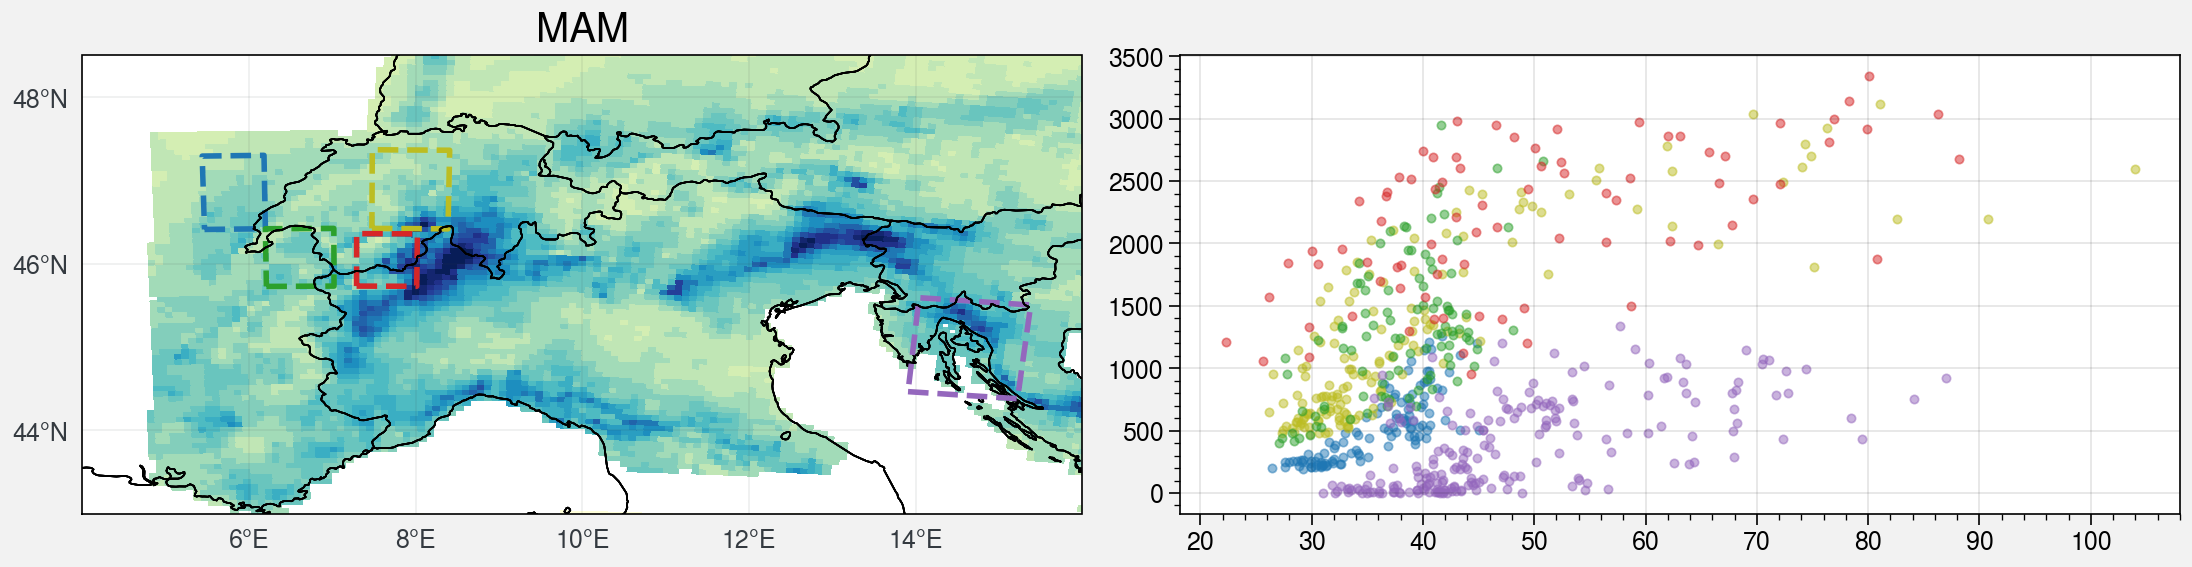

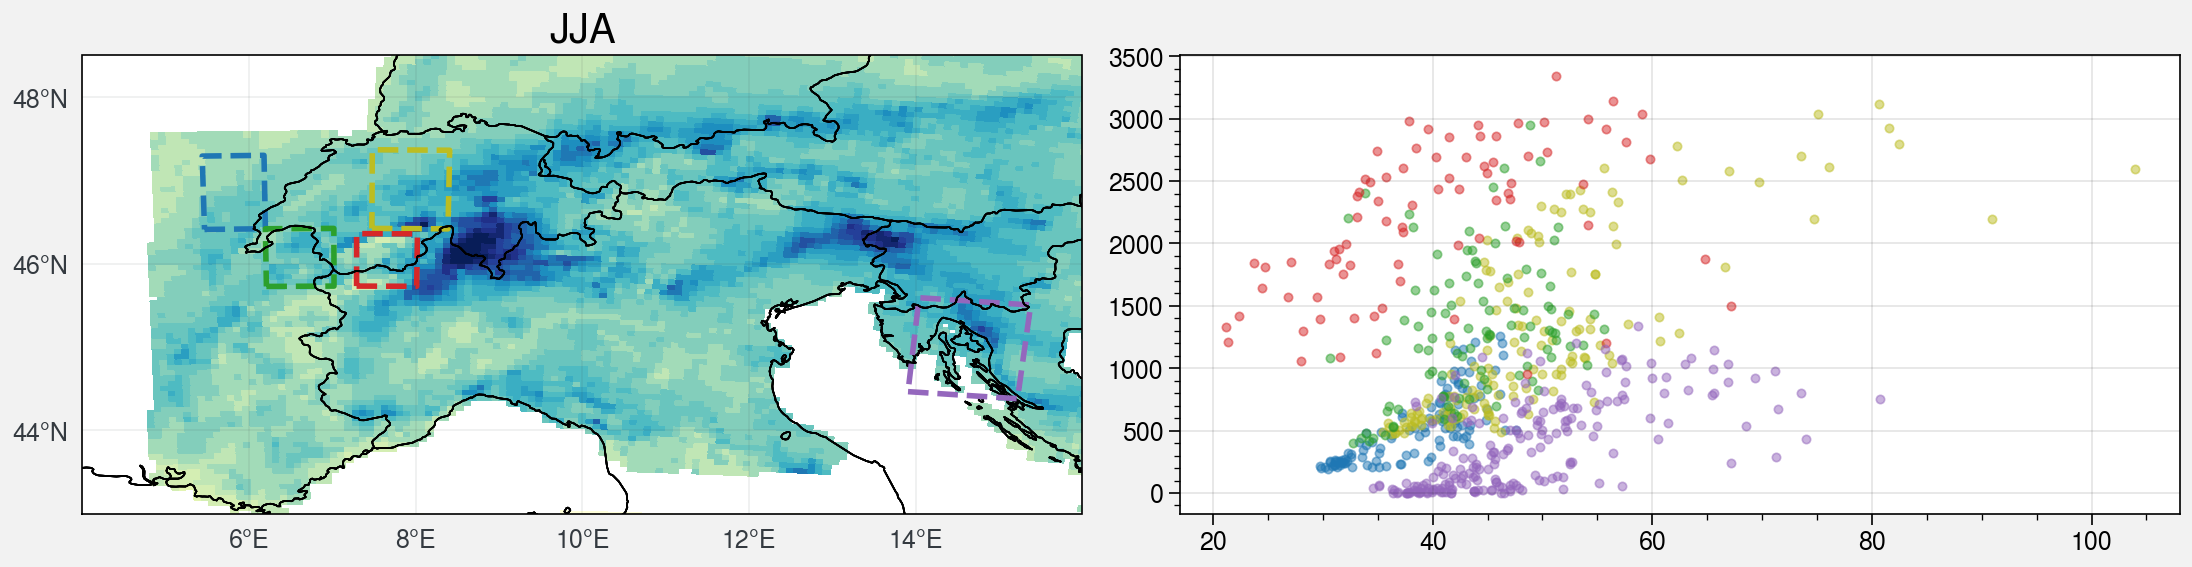

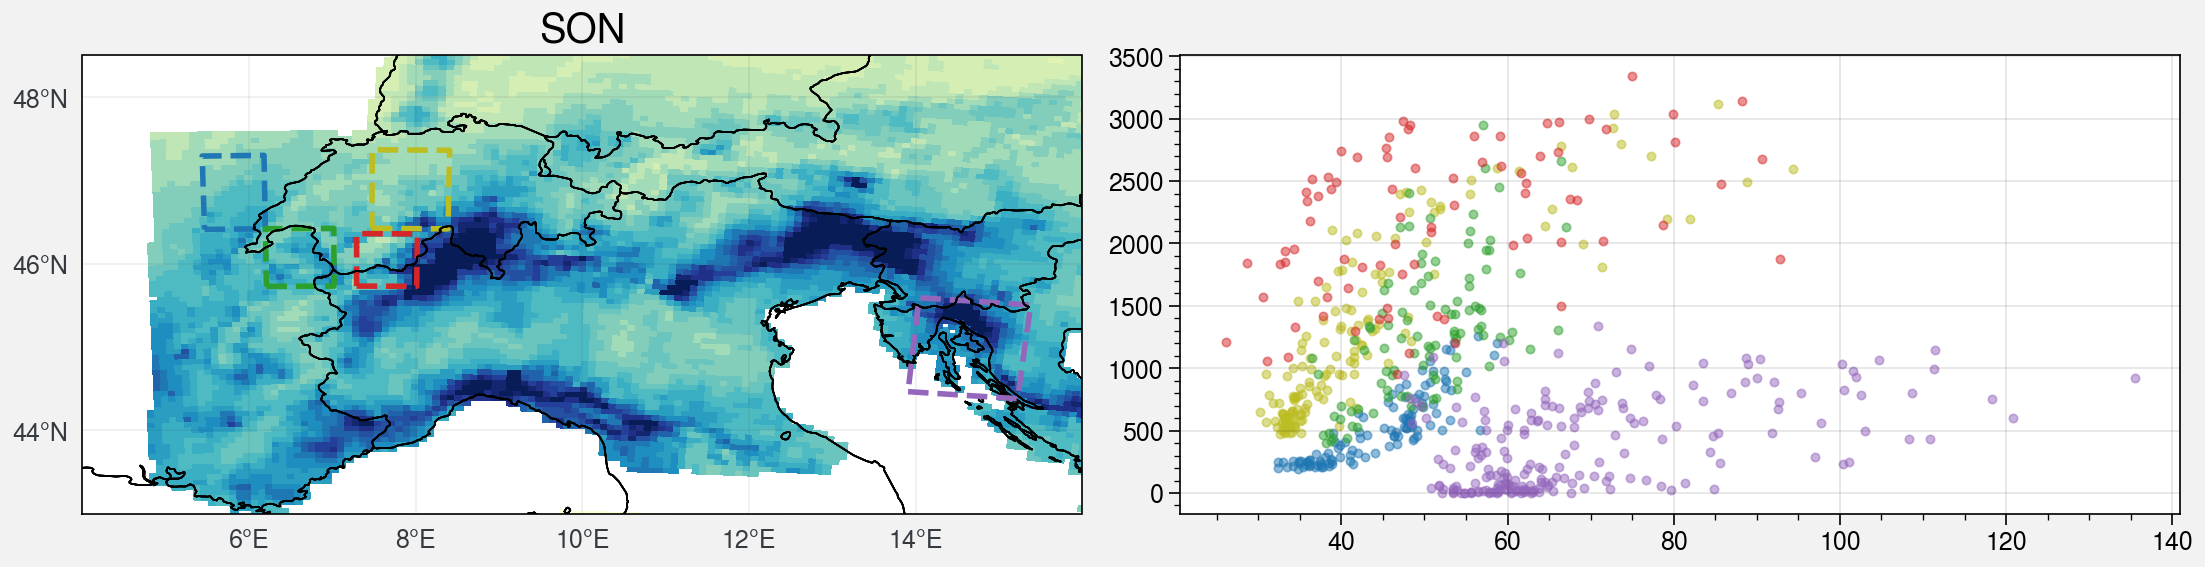

In [4]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/MARgrid_EUf.nc')
les_season_max = np.load('/home/philinat/Stage-M2/saved_data_APGD/les_season_max.npy')
seasonal_mean = np.mean(les_season_max,axis=0)

colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
fh, axh = pplt.subplots(proj='cyl', axwidth=8)
m=axh.pcolormesh(ds.LON, ds.LAT, ds.SH, levels=34,cmap=colors_land)
fh.colorbar(m,label= 'm.asl')
axh.format(**normal_format)#,ocean=True,oceancolor='royalblue',suptitle='7km topography')

colors = ['#1f77b4','#bcbd22', '#2ca02c', '#d62728', '#9467bd',  '#ff7f0e', '#17becf']

for season in range(4):
    f, axs = pplt.subplots(proj=('cyl',None),ncols=2, nrows=1, share=1, axwidth=5)
    for region in range(5):
        if region==0:
            i1 = 50 ; i2 = 58 ; j1 = 73 ; j2 = 87 # jura
            # i1 = 100 ; i2 = 120 ; j1 = 35 ; j2 = 45 # appenins
        if region==1:
            i1 = 72 ; i2 = 82 ; j1 = 73 ; j2 = 88 # suisse
        if region==2:
            i1 = 58 ; i2 = 67 ; j1 = 62 ; j2 = 73 # savoie
        if region==3:
            i1 = 70 ; i2 = 78 ; j1 = 62 ; j2 = 72 # mont rose
        if region==4:
            i1 = 145 ; i2 = 160 ; j1 = 45 ; j2 = 63 # croatie
        if region==5:
            i1 = 123 ; i2 = 137 ; j1 = 84 ; j2 = 90 # grossglokner
            # i1 = 100 ; i2 = 130 ; j1 = 82 ; j2 = 92 # tirol
            # i1 = 105 ; i2 = 120 ; j1 = 65 ; j2 = 80 # sud tirol

        m = axs[0].pcolormesh(ds.LON,ds.LAT,seasonal_mean[season,:,:],levels=np.linspace(0,100,21),cmap='YlGnBu' )
        axs[0].format(**normal_format,title=['DJF','MAM','JJA', 'SON'][season],titlesize='20px')

        axs[0].plot( [ ds.LON[j1,i1],ds.LON[j1,i2],ds.LON[j2,i2],ds.LON[j2,i1],ds.LON[j1,i1] ],
                  [ ds.LAT[j1,i1],ds.LAT[j1,i2],ds.LAT[j2,i2],ds.LAT[j2,i1],ds.LAT[j1,i1] ] , '--',color=colors[region],linewidth=2)
        if season==0:
            axh.plot( [ ds.LON[j1,i1],ds.LON[j1,i2],ds.LON[j2,i2],ds.LON[j2,i1],ds.LON[j1,i1] ],
                  [ ds.LAT[j1,i1],ds.LAT[j1,i2],ds.LAT[j2,i2],ds.LAT[j2,i1],ds.LAT[j1,i1] ] , '--',color=colors[region],linewidth=2)
            
        h = np.array(ds.SH[j1:j2,i1:i2].stack(z=('x','y')) )
        p = np.ndarray.flatten(seasonal_mean[season,j1:j2,i1:i2],order='F')
        #p = seasonal_mean[season,j1:j2,i1:i2].stack(z=('x','y'))
        axs[1].scatter( p, h ,marker='.',alpha=0.5,color=colors[region])

        # m, b = np.polyfit(p, h, 1)
        # x= np.linspace(np.min(p),np.max(p),2)
        # axs[1].plot(x, m*x + b,color=colors[region])